
Verwendetes Szenario: office
Ladepunkte: 2
Zeitraum: 2025-12-01 00:00:00 bis 2025-12-02 23:45:00
Horizont: 2 Tage

📊 Sessions
Ankünfte mit Ladebedarf: 13
mit Ladezugang: 7
ohne Ladezugang (drive_off): 6
Alle BEV haben Ziel-SoC erreicht.


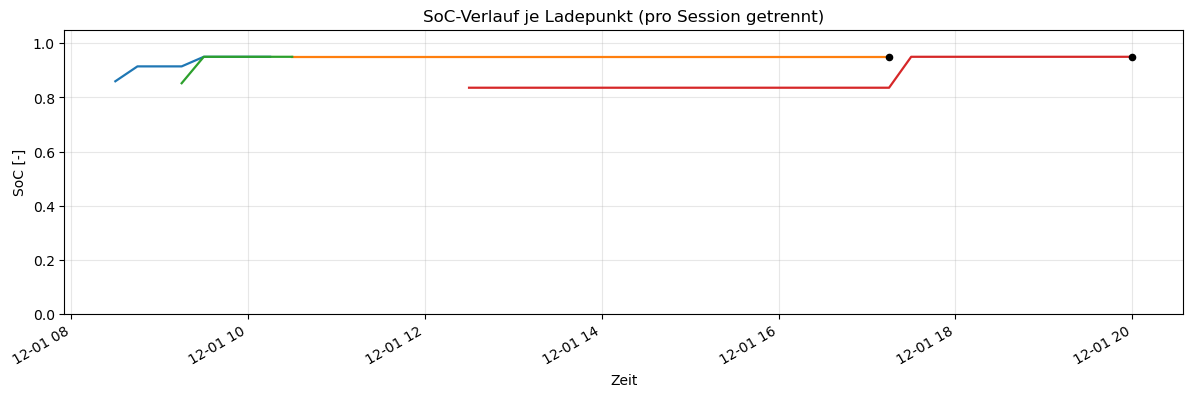

Anzahl echter Verstöße (SoC_vor_Step, Masterkurve): 0


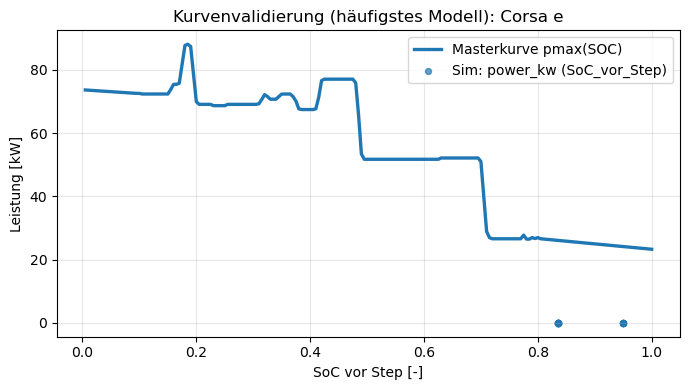

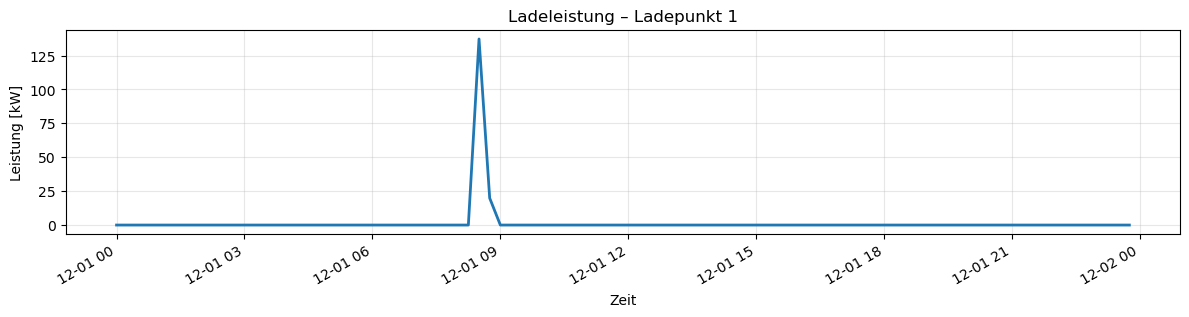

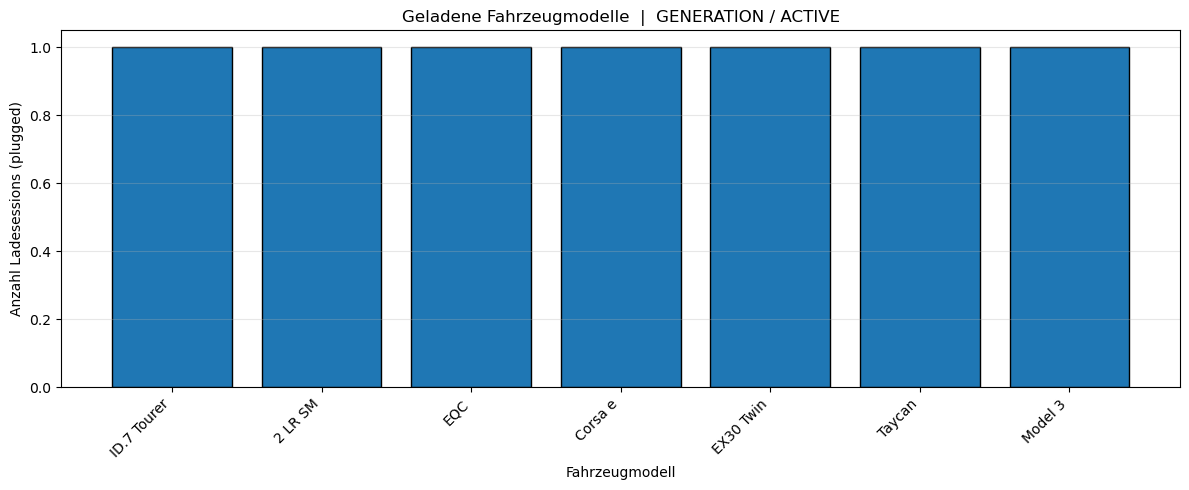

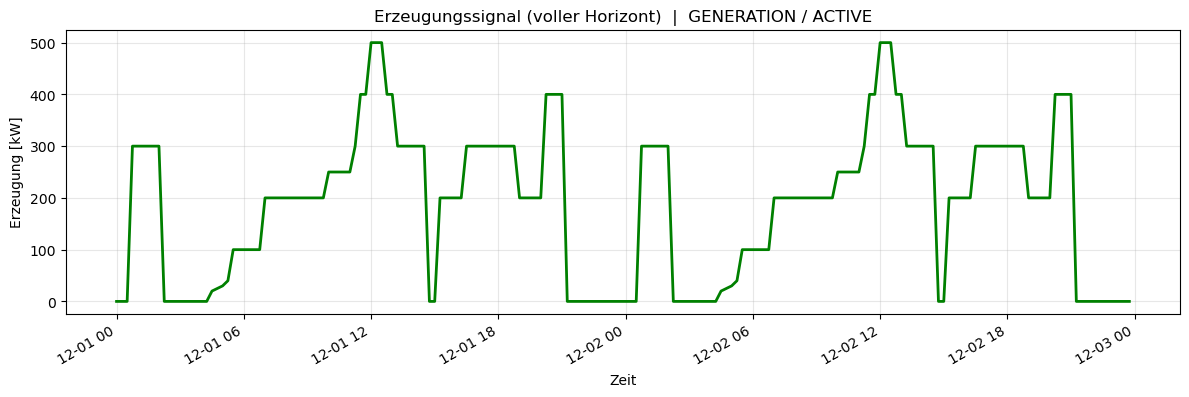

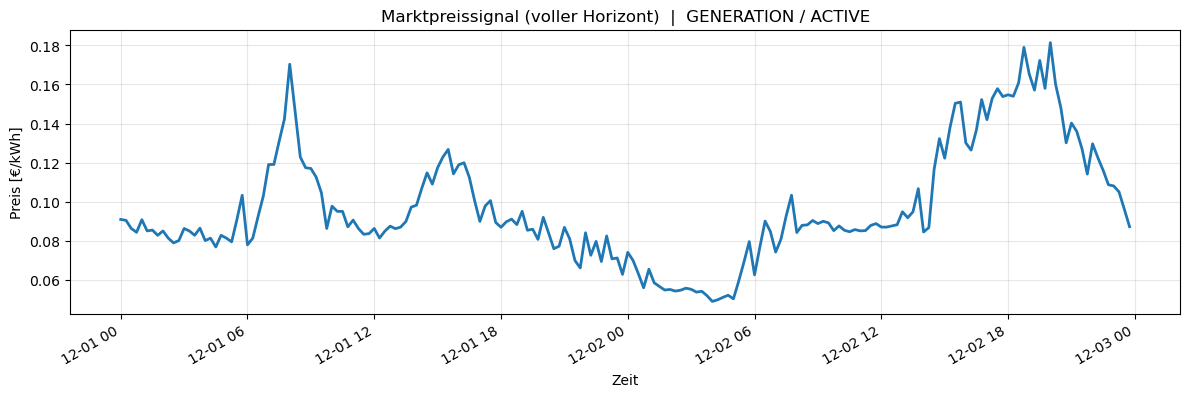

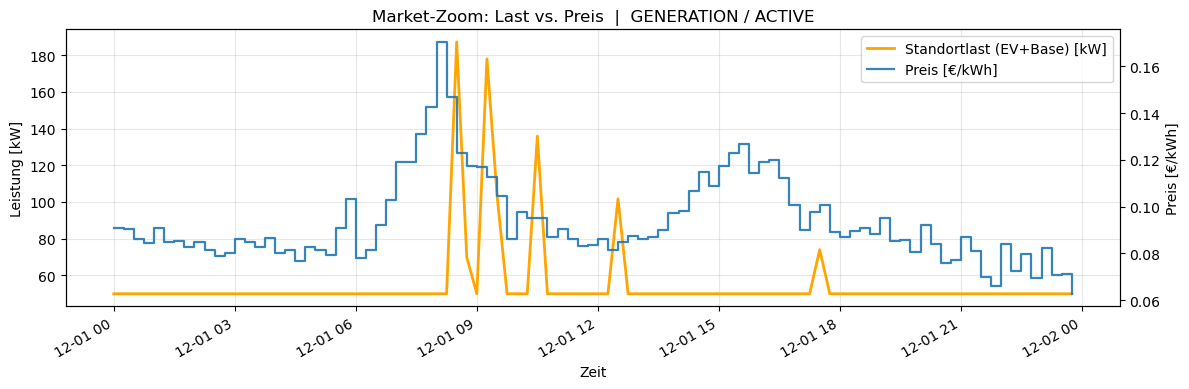

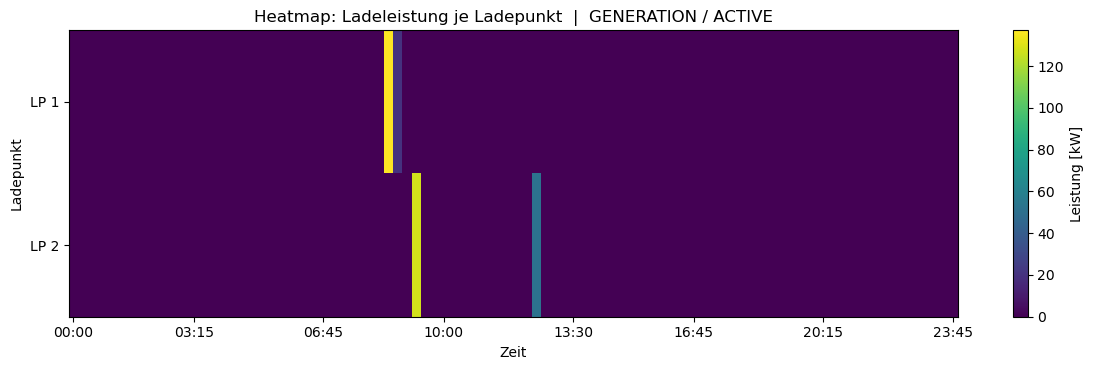

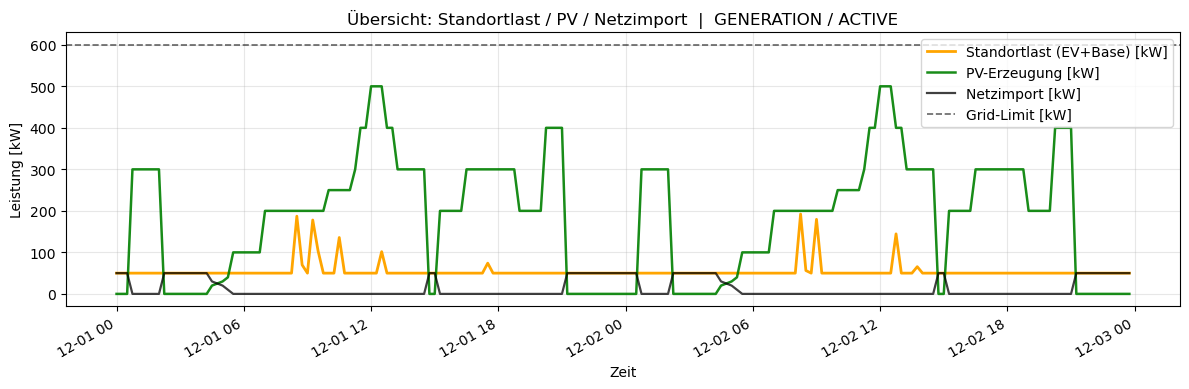

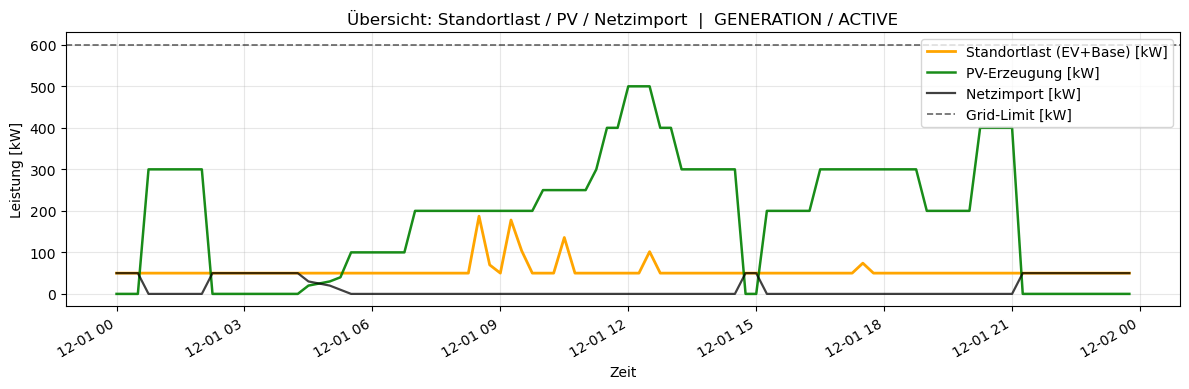

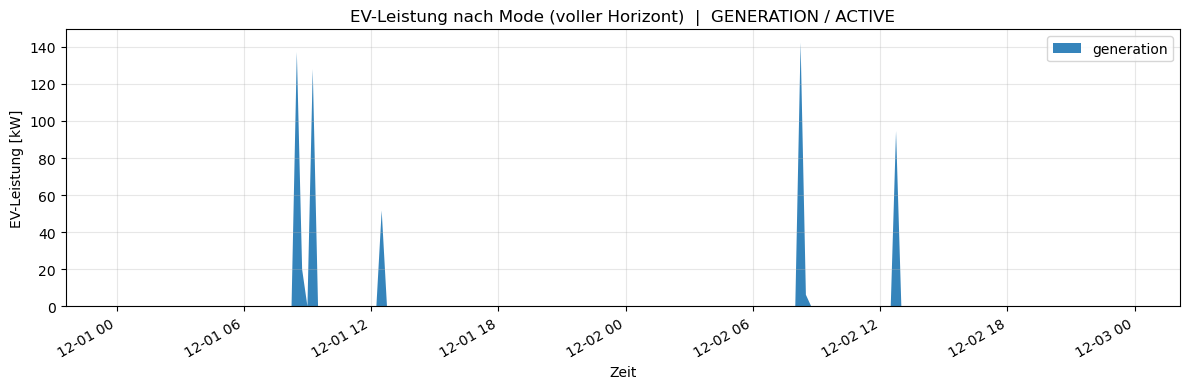

max |diff| [kW]: 129.61199473468398


,ev_load_kw,ev_from_tr_kw,diff_kw
ts,,,
2025-12-02 09:00:00,129.611995,0.0,129.611995
2025-12-01 10:30:00,85.827433,0.0,85.827433
2025-12-01 09:30:00,53.867807,0.0,53.867807
2025-12-01 17:30:00,24.020414,0.0,24.020414
2025-12-02 13:45:00,15.501516,0.0,15.501516
2025-12-01 00:00:00,0.000000,0.0,0.000000
2025-12-01 00:15:00,0.000000,0.0,0.000000
2025-12-01 00:30:00,0.000000,0.0,0.000000
2025-12-01 00:45:00,0.000000,0.0,0.000000


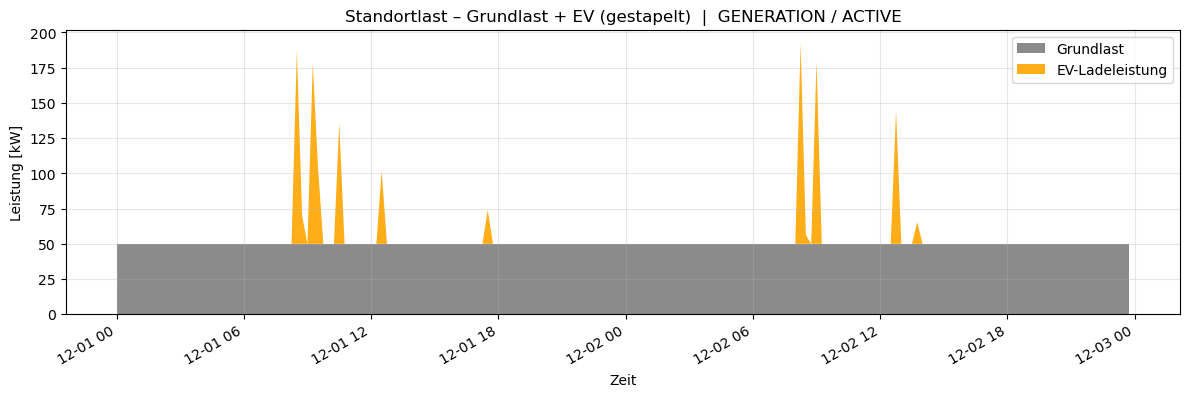

,vehicle_name,date,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,ID.7 Tourer,2025-12-01,08:29,10:21,1.86,40.35,0.0,0
1,2 LR SM,2025-12-01,09:01,10:36,1.57,40.14,0.0,1
2,EQC,2025-12-01,10:15,17:23,7.14,20.38,0.0,0
3,Corsa e,2025-12-01,12:15,20:12,7.96,17.99,0.0,1
4,EX30 Twin,2025-12-02,08:10,13:40,5.50,37.11,0.0,0
5,Taycan,2025-12-02,08:53,11:28,2.58,28.95,0.0,1
6,Model 3,2025-12-02,12:32,19:28,6.93,26.14,0.0,1



🧩 Nutzung der Lademodi – Sessions
Sessions mit Ladevorgang: 7
PV: 7
Market: 0
Immediate: 1
Mehrere Modi: 1

⚡ Energie nach Modus [kWh]
Generation: 205.83
Market:     0.00
Immediate:  5.23
max |grid - bilanz| = 0.0


,ts,ev_load_kw,base_load_kw,site_load_kw,pv_generation_kw,grid_import_kw_site,grid_import_kw_site_calc,diff
0,2025-12-01,0.0,50.0,50.0,0.0,50.0,50.0,0.0


In [5]:
# =============================================================================
# run_simulation.ipynb  (als .py-Zelle-Block lesbar)
# =============================================================================

# =============================================================================
# GLOBAL SETUP – einmal ganz oben ausführen
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

steps_per_day = None
t0 = None
t1 = None

def init_time_window(timestamps, scenario: dict, days: int = 1):
    if timestamps is None or len(timestamps) == 0:
        return None, None, None
    steps_per_day_local = int(24 * 60 / int(scenario["time_resolution_min"]))
    steps = int(max(1, days)) * steps_per_day_local
    t0_local = pd.to_datetime(timestamps[0])
    t1_local = pd.to_datetime(timestamps[min(len(timestamps) - 1, steps - 1)])
    return steps_per_day_local, t0_local, t1_local


# =============================================================================
# Imports
# =============================================================================
import sys, os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# =============================================================================
# Plot-Farben (global konsistent)
# =============================================================================
COLOR_GENERATION = "green"
COLOR_LOAD = "orange"
COLOR_BASELOAD = "#7f7f7f"
COLOR_MARKET = "tab:blue"


# =============================================================================
# Notebook UI Helpers
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}
    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")
    html = f"""
    <div style="font-size:18px;font-weight:800;color:{color};
        padding:10px 12px;border:2px solid {color};border-radius:12px;
        display:flex;align-items:center;gap:10px;width:fit-content;margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>"""
    display(HTML(html))

def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# Projektpfad setzen, damit "model" importierbar ist
# =============================================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# =============================================================================
# Imports aus dem Simulationsmodul
# =============================================================================
from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
)

try:
    from model.simulation import build_strategy_signal_series
except Exception:
    build_strategy_signal_series = None

try:
    from model.simulation import summarize_sessions_by_charging_mode, summarize_energy_by_charging_mode
except Exception:
    summarize_sessions_by_charging_mode = None
    summarize_energy_by_charging_mode = None


# =============================================================================
# 0) Zusatzplots: EV-Leistung nach Mode (dynamisch)
# =============================================================================
def plot_ev_power_by_mode_stack(
    df_tr: pd.DataFrame,
    start=None,
    end=None,
    include_idle: bool = False,          # True => "idle"/None werden als eigene Fläche geplottet (meist nicht gewünscht)
    drop_none_modes: bool = True,        # True => mode=None wird entfernt (empfohlen)
    min_power_kw: float = 1e-9,          # Filter für "echtes Laden"
    preferred_order: list[str] | None = None,  # z.B. ["generation","market","immediate"]
    legend_ncol: int = 4,
    title: str = "EV-Ladeleistung nach Modus über Zeit (dynamisch)",
):
    if df_tr is None or len(df_tr) == 0:
        print("df_tr ist leer.")
        return

    d = df_tr.copy()

    req = {"ts", "occupied", "power_kw", "mode"}
    missing = req - set(d.columns)
    if missing:
        print("Fehlende Spalten in df_tr:", sorted(missing))
        return

    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    if d["occupied"].dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true", "1", "yes"])

    d["power_kw"] = pd.to_numeric(d["power_kw"], errors="coerce").fillna(0.0)

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    d = d[d["occupied"] == True].copy()

    if drop_none_modes:
        d = d[d["mode"].notna()].copy()

    if not include_idle:
        d = d[~d["mode"].astype(str).str.lower().isin(["idle", "none", "nan"])].copy()

    d = d[d["power_kw"] > float(min_power_kw)].copy()

    if len(d) == 0:
        print("Keine Daten nach Filtern (occupied/mode/power).")
        return

    pivot = (
        d.pivot_table(index="ts", columns="mode", values="power_kw", aggfunc="sum")
        .fillna(0.0)
        .sort_index()
    )

    if pivot.empty:
        print("Pivot ist leer.")
        return

    cols = list(pivot.columns)
    if preferred_order is None:
        preferred_order = ["generation", "market", "immediate"]

    modes_sorted = [m for m in preferred_order if m in cols] + [m for m in cols if m not in preferred_order]
    ys = [pivot[m].to_numpy(dtype=float) for m in modes_sorted]

    plt.figure(figsize=(12, 4))
    plt.stackplot(
        pivot.index,
        *ys,
        labels=[str(m) for m in modes_sorted],
        alpha=0.9,
    )
    plt.legend(loc="upper right", ncol=min(int(legend_ncol), max(1, len(modes_sorted))))
    plt.grid(True, alpha=0.3)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("EV-Leistung [kW]")
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    print("Modes im Plot:", modes_sorted)


# =============================================================================
# 1) Szenario laden + Simulation
# =============================================================================
scenario = load_scenario(scenario_path)

(
    timestamps,
    load_kw,
    sessions,
    charging_counts,
    holiday_dates,
    charging_strategy,
    strategy_status,
    debug_rows,
    charger_traces,
) = simulate_load_profile(
    scenario,
    record_debug=True,
    record_charger_traces=True,
)

show_strategy_status_html(charging_strategy, strategy_status)

df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])
steps_per_day, t0, t1 = init_time_window(timestamps=timestamps, scenario=scenario, days=1)


# =============================================================================
# 2) Optional: Strategie-Signale (PV / Market)
# =============================================================================
generation_series = generation_ylabel = None
market_series = market_ylabel = None

if build_strategy_signal_series is not None:
    if charging_strategy.lower() == "generation":
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario, timestamps=timestamps, charging_strategy="generation",
            normalize_to_internal=True, strategy_resolution_min=15
        )
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario, timestamps=timestamps, charging_strategy="market",
            normalize_to_internal=True, strategy_resolution_min=15
        )
    elif charging_strategy.lower() == "market":
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario, timestamps=timestamps, charging_strategy="market",
            normalize_to_internal=True, strategy_resolution_min=15
        )


# =============================================================================
# 3) Timeseries DF (Debug = Source of Truth, fallback sonst)
# =============================================================================
def make_timeseries_df(timestamps, ev_load_kw, scenario, debug_rows=None, generation_series=None, market_series=None):
    df = pd.DataFrame({"ts": pd.to_datetime(timestamps), "ev_load_kw": np.asarray(ev_load_kw, float)})

    # Debug zuerst mergen
    if debug_rows is not None:
        df_dbg = pd.DataFrame(debug_rows).copy()
        if len(df_dbg) and "ts" in df_dbg.columns:
            df_dbg["ts"] = pd.to_datetime(df_dbg["ts"], errors="coerce")
            df_dbg = df_dbg.dropna(subset=["ts"]).drop_duplicates(subset=["ts"], keep="first")
            df = df.merge(df_dbg, on="ts", how="left")

    # Base Load: Debug bevorzugen, sonst berechnen
    if "base_load_kw" not in df.columns or df["base_load_kw"].isna().all():
        base = build_base_load_series(scenario=scenario, timestamps=timestamps, base_load_resolution_min=15)
        if base is None:
            base = np.zeros_like(df["ev_load_kw"].values)
        df["base_load_kw"] = np.asarray(base, float)

    # Standortlast immer konsistent
    df["site_load_kw"] = df["ev_load_kw"] + df["base_load_kw"]

    # PV: wenn Debug fehlt, aus Signal; wenn Debug vorhanden, Signal separat behalten
    if generation_series is not None:
        if "pv_generation_kw" not in df.columns or df["pv_generation_kw"].isna().all():
            df["pv_generation_kw"] = np.asarray(generation_series, float)
        else:
            df["pv_signal_kw"] = np.asarray(generation_series, float)

    # Market: analog
    if market_series is not None:
        if "price_eur_per_kwh" not in df.columns or df["price_eur_per_kwh"].isna().all():
            df["price_eur_per_kwh"] = np.asarray(market_series, float)
        else:
            df["price_signal_eur_per_kwh"] = np.asarray(market_series, float)

    return df

df_ts = make_timeseries_df(
    timestamps=timestamps,
    ev_load_kw=load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=generation_series,
    market_series=market_series,
)


# =============================================================================
# 4) KPIs kurz
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", scenario["site"]["number_chargers"])
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", scenario["simulation_horizon_days"], "Tage")

summary = summarize_sessions(sessions)
print("\n📊 Sessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV haben Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Nicht erreicht:", len(df_not_reached))
    display(df_not_reached)


# =============================================================================
# 5) Daytype Kalender (nur wenn du es brauchst)
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])
days_by_type_calendar = get_daytype_calendar(start_datetime=start_dt, horizon_days=horizon_days, holiday_dates=holiday_dates)
sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)


# =============================================================================
# 6) SoC je Ladepunkt (Zoom) – PRO SESSION getrennt (kein "runter" durch Sessionwechsel)
# =============================================================================
def plot_soc_by_chargers(df_tr, charger_ids=None, start=None, end=None, use_raw=True):
    if df_tr is None or len(df_tr) == 0:
        print("df_tr leer.")
        return

    req = {"ts","charger_id","occupied","session_id","soc","soc_raw"}
    if not req.issubset(df_tr.columns):
        print("df_tr fehlt:", sorted(req - set(df_tr.columns)))
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d = d.dropna(subset=["ts","charger_id"]).copy()
    d["charger_id"] = d["charger_id"].astype(int)

    if charger_ids is not None:
        d = d[d["charger_id"].isin([int(x) for x in charger_ids])]
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if d["occupied"].dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true","1","yes"])

    col = "soc_raw" if use_raw else "soc"
    d[col] = pd.to_numeric(d[col], errors="coerce")

    d = d[(d["occupied"]==True) & d["session_id"].notna() & d[col].notna()].sort_values(["charger_id","ts"])
    if len(d) == 0:
        print("Keine belegten Ladepunkte mit SoC im Fenster.")
        return

    plt.figure(figsize=(12,4))
    ax = plt.gca()

    for cid, g in d.groupby("charger_id"):
        # pro Session getrennt plotten (damit kein "SoC runter" beim Sessionwechsel entsteht)
        for sid, gg in g.groupby("session_id"):
            ax.plot(gg["ts"], gg[col], linewidth=1.6)

        last = g.iloc[-1]
        ax.scatter([last["ts"]],[last[col]], color="black", s=20, zorder=5)

    ax.set_xlabel("Zeit")
    ax.set_ylabel("SoC [-]")
    ax.set_ylim(0,1.05)
    ax.set_title("SoC-Verlauf je Ladepunkt (pro Session getrennt)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

plot_soc_by_chargers(
    df_tr,
    charger_ids=list(range(int(scenario["site"]["number_chargers"]))),
    start=t0,
    end=t1,
    use_raw=True
)


# =============================================================================
# 7) Kurvenvalidierung (CSV Masterkurve vs Sim)
# =============================================================================
def validate_against_master_curves(df_tr: pd.DataFrame, sessions: list[dict], scenario: dict, start=None, end=None):
    """
    Erwartet: df_tr hat soc_raw (SoC nach Step ohne Clamp) und power_kw.
    Prüft: power_kw <= pmax(master, SoC_vor_Step) + eps
    """
    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"])

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    d = d[(d["occupied"]==True) & d["session_id"].notna()].copy()
    d["power_kw"] = pd.to_numeric(d["power_kw"], errors="coerce").fillna(0.0)

    if "soc_raw" not in d.columns:
        raise ValueError("df_tr hat keine 'soc_raw'. (simulation.py Trace-Logging prüfen)")

    d["soc_raw"] = pd.to_numeric(d["soc_raw"], errors="coerce")
    d = d[d["soc_raw"].notna()].copy()
    d = d.sort_values(["session_id","ts"]).reset_index(drop=True)

    # SoC_vor_Step = Vorwert (shift)
    d["soc_prev_raw"] = d.groupby("session_id")["soc_raw"].shift(1)
    d = d[d["soc_prev_raw"].notna()].copy()
    d["soc_prev_raw"] = d["soc_prev_raw"].clip(0.0, 1.0)

    session_by_id = {s.get("session_id"): s for s in sessions if s.get("session_id") is not None}

    def pmax_from_session_curve(session_id, soc):
        s = session_by_id.get(session_id)
        if s is None:
            return np.nan
        soc_grid = s.get("soc_grid")
        p_grid = s.get("power_grid_kw")
        if soc_grid is None or p_grid is None:
            return np.nan
        return float(np.interp(float(soc), np.asarray(soc_grid, float), np.asarray(p_grid, float)))

    d["pmax_vehicle_kw"] = [
        pmax_from_session_curve(sid, socp) for sid, socp in zip(d["session_id"].values, d["soc_prev_raw"].values)
    ]

    eps = 1e-6
    viol = d[(d["pmax_vehicle_kw"].notna()) & (d["power_kw"] > d["pmax_vehicle_kw"] + eps)].copy()
    viol["ratio"] = viol["power_kw"] / viol["pmax_vehicle_kw"].replace(0, np.nan)
    viol = viol.sort_values(["ratio","power_kw"], ascending=[False, False])

    print("Anzahl echter Verstöße (SoC_vor_Step, Masterkurve):", len(viol))
    if len(viol):
        display(viol[["ts","charger_id","session_id","vehicle_name","soc_prev_raw","power_kw","pmax_vehicle_kw","ratio"]].head(20))

    # Plot Beispiel: häufigstes Modell
    if "vehicle_name" in d.columns and d["vehicle_name"].notna().any():
        model = d["vehicle_name"].value_counts().index[0]
        dd = d[d["vehicle_name"] == model].copy()
        sid_any = dd["session_id"].iloc[0]
        s_any = session_by_id.get(sid_any, {})
        soc_curve = np.asarray(s_any.get("soc_grid", []), float)
        p_curve = np.asarray(s_any.get("power_grid_kw", []), float)

        if len(soc_curve) and len(p_curve):
            plt.figure(figsize=(7,4))
            plt.plot(soc_curve, p_curve, linewidth=2.4, label="Masterkurve pmax(SOC)")
            plt.scatter(dd["soc_prev_raw"], dd["power_kw"], s=18, alpha=0.7, label="Sim: power_kw (SoC_vor_Step)")
            if len(viol):
                vv = viol[viol["vehicle_name"] == model]
                if len(vv):
                    plt.scatter(vv["soc_prev_raw"], vv["power_kw"], s=30, alpha=0.95, label="Verstöße", marker="x")
            plt.xlabel("SoC vor Step [-]")
            plt.ylabel("Leistung [kW]")
            plt.title(f"Kurvenvalidierung (häufigstes Modell): {model}")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

    return d, viol

d_curvecheck, viol = validate_against_master_curves(df_tr, sessions, scenario, start=t0, end=t1)


# =============================================================================
# 8) Leistung einzelner Ladepunkte (Zoom)
# =============================================================================
def plot_power_per_charger(df_tr, charger_id, start=None, end=None):
    d = df_tr[df_tr["charger_id"] == charger_id].copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    plt.figure(figsize=(12,3))
    plt.plot(d["ts"], d["power_kw"], linewidth=2.0)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(f"Ladeleistung – Ladepunkt {charger_id + 1}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

plot_power_per_charger(df_tr, charger_id=0, start=t0, end=t1)


# =============================================================================
# 9) Fahrzeugzählung
# =============================================================================
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name","") for s in sessions_plugged])

plt.figure(figsize=(12,5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# 10) Strategy-only Plots (optional)
# =============================================================================
if generation_series is not None and generation_ylabel is not None:
    plt.figure(figsize=(12,4))
    plt.plot(timestamps, generation_series, linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel(generation_ylabel)
    plt.title(decorate_title_with_status("Erzeugungssignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12,4))
    plt.plot(timestamps, market_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 11) Master-Plots
# =============================================================================

def plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=None, end=None):
    d = df_ts.copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]
    if len(d) == 0:
        print("plot_site_overview: kein Datenfenster.")
        return

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(d["ts"], d["site_load_kw"], linewidth=2.0, color=COLOR_LOAD,
            label="Standortlast (EV+Base) [kW]")

    if "pv_generation_kw" in d.columns and d["pv_generation_kw"].notna().any():
        ax.plot(d["ts"], d["pv_generation_kw"], linewidth=1.8, color=COLOR_GENERATION, alpha=0.9,
                label="PV-Erzeugung [kW]")

    if "grid_import_kw_site" in d.columns and d["grid_import_kw_site"].notna().any():
        ax.plot(d["ts"], d["grid_import_kw_site"], linewidth=1.6, color="black", alpha=0.75,
                label="Netzimport [kW]")
        gl = float(scenario["site"]["grid_limit_p_avb_kw"])
        ax.axhline(gl, linewidth=1.2, alpha=0.6, linestyle="--", color="black",
                   label="Grid-Limit [kW]")

    ax.set_xlabel("Zeit")
    ax.set_ylabel("Leistung [kW]")
    ax.set_title(decorate_title_with_status("Übersicht: Standortlast / PV / Netzimport",
                                            charging_strategy, strategy_status))
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_market_behavior_zoom(df_ts, charging_strategy, strategy_status, start=None, end=None):
    d = df_ts.copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]
    if len(d) == 0:
        print("plot_market_behavior_zoom: kein Datenfenster.")
        return
    if "price_eur_per_kwh" not in d.columns or not d["price_eur_per_kwh"].notna().any():
        print("plot_market_behavior_zoom: kein Market-Preis in df_ts.")
        return

    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(d["ts"], d["site_load_kw"], linewidth=2.0, color=COLOR_LOAD,
             label="Standortlast (EV+Base) [kW]")
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(d["ts"], d["price_eur_per_kwh"], where="post",
             linewidth=1.6, color=COLOR_MARKET, alpha=0.9,
             label="Preis [€/kWh]")
    ax2.set_ylabel("Preis [€/kWh]")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right")

    ax1.set_title(decorate_title_with_status("Market-Zoom: Last vs. Preis",
                                             charging_strategy, strategy_status))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=None, end=None):
    if df_tr is None or len(df_tr) == 0:
        print("plot_charger_power_heatmap: df_tr leer.")
        return

    req = {"ts", "charger_id", "power_kw"}
    if not req.issubset(df_tr.columns):
        print("plot_charger_power_heatmap: df_tr fehlen:", sorted(req - set(df_tr.columns)))
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d["power_kw"] = pd.to_numeric(d["power_kw"], errors="coerce")
    d = d.dropna(subset=["ts", "charger_id"]).copy()
    d["charger_id"] = d["charger_id"].astype(int)
    d["power_kw"] = d["power_kw"].fillna(0.0)

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]
    if len(d) == 0:
        print("plot_charger_power_heatmap: kein Datenfenster.")
        return

    pv = (
        d.pivot_table(index="charger_id", columns="ts", values="power_kw", aggfunc="first")
         .sort_index()
         .fillna(0.0)
    )

    fig, ax = plt.subplots(figsize=(12, 3.8))
    im = ax.imshow(pv.values, aspect="auto", interpolation="nearest")

    ax.set_title(decorate_title_with_status("Heatmap: Ladeleistung je Ladepunkt",
                                            charging_strategy, strategy_status))
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Ladepunkt")

    ax.set_yticks(np.arange(pv.shape[0]))
    ax.set_yticklabels([f"LP {i+1}" for i in pv.index])

    cols = pv.columns.to_list()
    if len(cols) > 1:
        n_ticks = min(8, len(cols))
        tick_idx = np.linspace(0, len(cols) - 1, n_ticks).astype(int)
        ax.set_xticks(tick_idx)
        ax.set_xticklabels([pd.to_datetime(cols[i]).strftime("%H:%M") for i in tick_idx], rotation=0)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Leistung [kW]")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Aufrufe (NACH den Funktionsdefinitionen)
# 1) Market-Zoom
# 2) Heatmap
# 3) Übersicht (voll)
# 4) Übersicht (Zoom)
# ------------------------------------------------------------
if "price_eur_per_kwh" in df_ts.columns and df_ts["price_eur_per_kwh"].notna().any():
    plot_market_behavior_zoom(df_ts, charging_strategy, strategy_status, start=t0, end=t1)

plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=t0, end=t1)

plot_site_overview(df_ts, scenario, charging_strategy, strategy_status)
plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=t0, end=t1)



# =============================================================================
# 11b) NEU: EV-Leistung nach Mode gestapelt (dynamisch)
# =============================================================================
def plot_ev_power_by_mode_stack(
    df_tr: pd.DataFrame,
    df_ts: pd.DataFrame,  # <- wichtig: liefert den vollen Horizont
    preferred_order=("generation", "market", "immediate"),
    include_idle=False,
    drop_none_modes=True,
    title="EV-Leistung nach Mode (voller Horizont)",
):
    if df_tr is None or len(df_tr) == 0:
        print("plot_ev_power_by_mode_stack: df_tr leer.")
        return
    if df_ts is None or len(df_ts) == 0 or "ts" not in df_ts.columns:
        print("plot_ev_power_by_mode_stack: df_ts fehlt oder hat keine 'ts'.")
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    # Mode-Spalte normalisieren
    if "mode" not in d.columns:
        d["mode"] = None
    d["mode"] = d["mode"].astype(object)

    # Leistung sauber numerisch
    d["power_kw"] = pd.to_numeric(d.get("power_kw", 0.0), errors="coerce").fillna(0.0)

    # Optional: None-Modes rauswerfen (Achtung: das kann "idle" implizit entfernen)
    if drop_none_modes:
        d = d[d["mode"].notna()].copy()

    # Optional: idle rauswerfen (wenn du idle explizit als Label nutzt)
    if not include_idle:
        d = d[d["mode"].astype(str).str.lower().ne("idle")].copy()

    # 1) Aggregation: Summe Leistung je ts & mode
    g = d.groupby(["ts", "mode"], as_index=False)["power_kw"].sum()

    # 2) Pivot auf ts x mode
    pivot = g.pivot(index="ts", columns="mode", values="power_kw")

    # 3) REINDEX auf vollen Simulationshorizont
    full_ts = pd.to_datetime(df_ts["ts"], errors="coerce")
    pivot = pivot.reindex(full_ts).fillna(0.0)

    # 4) Dynamische Mode-Reihenfolge: preferred zuerst, dann Rest alphabetisch
    cols = list(pivot.columns)
    pref = [c for c in preferred_order if c in cols]
    rest = sorted([c for c in cols if c not in pref], key=lambda x: str(x))
    ordered_cols = pref + rest
    pivot = pivot[ordered_cols]

    # 5) Plot: alle Modes dynamisch stacked
    y_arrays = [pivot[c].values for c in pivot.columns]

    plt.figure(figsize=(12, 4))
    plt.stackplot(pivot.index, *y_arrays, labels=[str(c) for c in pivot.columns], alpha=0.9)
    plt.xlabel("Zeit")
    plt.ylabel("EV-Leistung [kW]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

plot_ev_power_by_mode_stack(
    df_tr=df_tr,
    df_ts=df_ts,
    preferred_order=("generation", "market", "immediate"),
    include_idle=False,
    drop_none_modes=True,
    title=decorate_title_with_status("EV-Leistung nach Mode (voller Horizont)", charging_strategy, strategy_status),
)

# Vergleich: "Ground Truth" EV-Last aus df_ts vs. Summe power_kw aus df_tr
p_tr = (
    df_tr.assign(ts=pd.to_datetime(df_tr["ts"], errors="coerce"))
         .groupby("ts")["power_kw"].sum()
)

cmp = df_ts.copy()
cmp["ts"] = pd.to_datetime(cmp["ts"], errors="coerce")
cmp = cmp.set_index("ts")

cmp["ev_from_tr_kw"] = p_tr.reindex(cmp.index).fillna(0.0)
cmp["diff_kw"] = cmp["ev_load_kw"] - cmp["ev_from_tr_kw"]

print("max |diff| [kW]:", float(cmp["diff_kw"].abs().max()))
display(cmp.loc[cmp["diff_kw"].abs().nlargest(10).index, ["ev_load_kw","ev_from_tr_kw","diff_kw"]])


# =============================================================================
# 12) Gestapelte Standortlast (Base + EV)
# =============================================================================
plt.figure(figsize=(12,4))
plt.stackplot(
    df_ts["ts"],
    df_ts["base_load_kw"],
    df_ts["ev_load_kw"],
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()


# =============================================================================
# 13) Plugged Sessions Preview
# =============================================================================
def build_plugged_sessions_preview_table(sessions, n: int = 20) -> pd.DataFrame:
    if not sessions:
        return pd.DataFrame()
    plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
    if not plugged:
        return pd.DataFrame()

    plugged = sorted(plugged, key=lambda s: s["arrival_time"])
    rows = []
    for s in plugged[:n]:
        arr = s.get("arrival_time")
        dep = s.get("departure_time")
        parking_h = (dep - arr).total_seconds()/3600.0 if (arr and dep) else None
        rows.append({
            "vehicle_name": s.get("vehicle_name",""),
            "date": arr.date() if arr else None,
            "arrival_time": arr.strftime("%H:%M") if arr else None,
            "departure_time": dep.strftime("%H:%M") if dep else None,
            "parking_hours": round(parking_h, 2) if parking_h is not None else None,
            "delivered_energy_kwh": round(float(s.get("delivered_energy_kwh", 0.0)), 2),
            "remaining_energy_kwh": round(float(s.get("energy_required_kwh", 0.0)), 2),
            "charger_id": s.get("_charger_id"),
        })
    return pd.DataFrame(rows)

display(build_plugged_sessions_preview_table(sessions, n=20))


# =============================================================================
# 14) Debugging: Nutzung der Lademodi (optional)
# =============================================================================
if summarize_sessions_by_charging_mode is not None and summarize_energy_by_charging_mode is not None:
    mode_counts = summarize_sessions_by_charging_mode(sessions)
    mode_energy = summarize_energy_by_charging_mode(sessions)

    print("\n🧩 Nutzung der Lademodi – Sessions")
    print("Sessions mit Ladevorgang:", mode_counts["sessions_with_any_charging"])
    print("PV:", mode_counts["sessions_charged_with_generation"])
    print("Market:", mode_counts["sessions_charged_with_market"])
    print("Immediate:", mode_counts["sessions_charged_with_immediate"])
    print("Mehrere Modi:", mode_counts["sessions_with_multiple_modes"])

    print("\n⚡ Energie nach Modus [kWh]")
    print(f"Generation: {mode_energy['generation']:.2f}")
    print(f"Market:     {mode_energy['market']:.2f}")
    print(f"Immediate:  {mode_energy['immediate']:.2f}")


# =============================================================================
# 15) Mini-Check: Grid-Bilanz (EINMAL)
# =============================================================================
cols_need = ["site_load_kw", "pv_generation_kw", "grid_import_kw_site"]
if all(c in df_ts.columns for c in cols_need):
    df_ts["grid_import_kw_site_calc"] = (df_ts["site_load_kw"] - df_ts["pv_generation_kw"]).clip(lower=0.0)
    df_ts["diff"] = df_ts["grid_import_kw_site"] - df_ts["grid_import_kw_site_calc"]
    i = df_ts["diff"].abs().idxmax()
    print("max |grid - bilanz| =", float(df_ts["diff"].abs().max()))
    display(df_ts.loc[[i], ["ts","ev_load_kw","base_load_kw","site_load_kw","pv_generation_kw",
                           "grid_import_kw_site","grid_import_kw_site_calc","diff"]])
else:
    print("Mini-Check übersprungen. Fehlende Spalten:", [c for c in cols_need if c not in df_ts.columns])
